In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
# Reads data from CSV file
teams = pd.read_csv("teams.csv")

In [3]:
# Fields of interest
teams = teams[["team", "country", "year", "athletes", "age", "prev_medals", "medals"]]
teams

,team,country,year,athletes,age,prev_medals,medals
0,AFG,Afghanistan,1964,8,22.0,0.0,0
1,AFG,Afghanistan,1968,5,23.2,0.0,0
2,AFG,Afghanistan,1972,8,29.0,0.0,0
3,AFG,Afghanistan,1980,11,23.6,0.0,0
4,AFG,Afghanistan,2004,5,18.6,0.0,0
...,...,...,...,...,...,...,...
2139,ZIM,Zimbabwe,2000,26,25.0,0.0,0
2140,ZIM,Zimbabwe,2004,14,25.1,0.0,3
2141,ZIM,Zimbabwe,2008,16,26.1,3.0,4
2142,ZIM,Zimbabwe,2012,9,27.3,4.0,0


In [4]:
# Correlation of medals with other categories
teams.corr()["medals"]

year          -0.021603
athletes       0.840817
age            0.025096
prev_medals    0.920048
medals         1.000000
Name: medals, dtype: float64

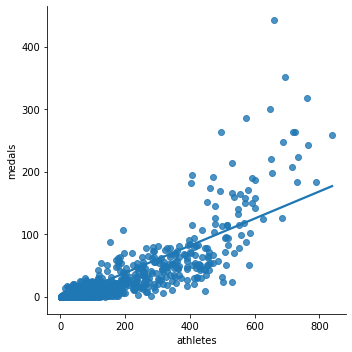

In [5]:
#Strong correlation with athletes
sns.lmplot(x="athletes", y="medals", data=teams, fit_reg=True, ci=None)

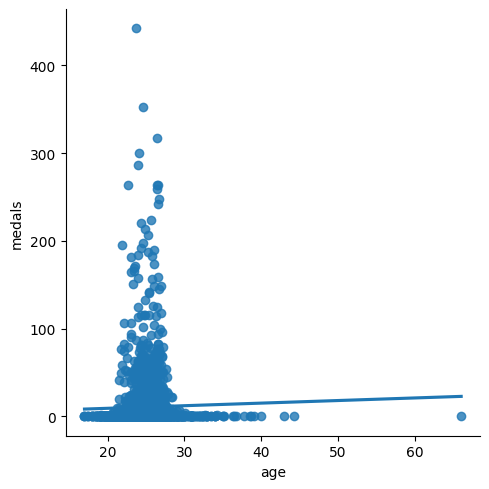

In [6]:
# Weak correlation with age
sns.lmplot(x="age", y="medals", data=teams, fit_reg=True, ci=None)

Text(0, 0.5, 'Number of Countries')

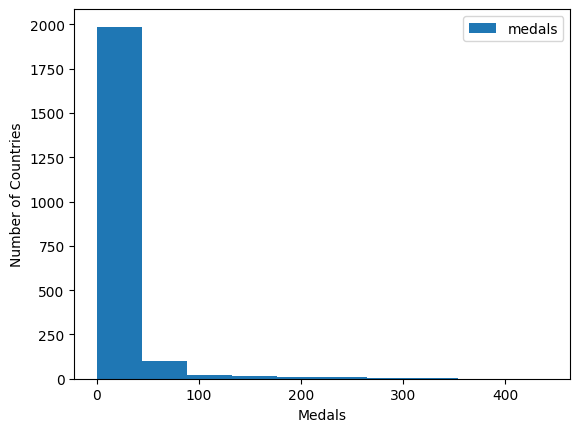

In [7]:
# Num countries vs how many medals they received
h = teams.plot.hist(y="medals")
h.set_xlabel("Medals")
h.set_ylabel("Number of Countries")

In [8]:
# Finds missing data
teams[teams.isnull().any(axis=1)]

,team,country,year,athletes,age,prev_medals,medals
19,ALB,Albania,1992,9,25.3,NaN,0
26,ALG,Algeria,1964,7,26.0,NaN,0
39,AND,Andorra,1976,3,28.3,NaN,0
50,ANG,Angola,1980,17,17.4,NaN,0
59,ANT,Antigua and Barbuda,1976,17,23.2,NaN,0
...,...,...,...,...,...,...,...
2092,VIN,Saint Vincent and the Grenadines,1988,6,20.5,NaN,0
2103,YAR,North Yemen,1984,3,27.7,NaN,0
2105,YEM,Yemen,1992,8,19.6,NaN,0
2112,YMD,South Yemen,1988,5,23.6,NaN,0


In [9]:
# Removes missing data
teams = teams.dropna()

In [10]:
# Splits data 80-20 for training/testing
train = teams[teams["year"] < 2012].copy()
test = teams[teams["year"] >= 2012].copy()

In [11]:
# About 80% of data
train.shape

(1609, 7)

In [12]:
# About 20% of data
test.shape

(405, 7)

In [13]:
# Linear regression class 
reg = LinearRegression()

In [14]:
# Identify fields to be used in predicting medal count
predictors = ["athletes", "prev_medals"]
target = "medals"

In [15]:
# Fits linear regression model
reg.fit(train[predictors], train["medals"])

LinearRegression()

In [16]:
# Generate predictions using test data set
predictions = reg.predict(test[predictors])

In [17]:
# Adds predictions as field in test data
test["predictions"] = predictions

In [18]:
# Removes negative predictions (replaces as 0)
test.loc[test["predictions"] < 0, "predictions"] = 0

In [19]:
# Rounds predictions to whole numbers
test["predictions"] = test["predictions"].round()

In [20]:
# View of actual vs predicted number of medals
test[["medals", "predictions"]]

,medals,predictions
6,1,0.0
7,0,0.0
24,0,0.0
25,0,0.0
37,1,2.0
...,...,...
2111,0,0.0
2131,0,0.0
2132,0,0.0
2142,0,2.0


In [21]:
# Finds error
# On average, predictions were within 3.3 medals of actual number
error = mean_absolute_error(test["medals"], test["predictions"])
error

3.2987654320987656

In [22]:
teams.describe()["medals"]

count    2014.000000
mean       10.990070
std        33.627528
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max       442.000000
Name: medals, dtype: float64

In [23]:
# Difference between actual vs predicted
errors = (test["medals"] - test["predictions"]).abs()
errors

6       1.0
7       0.0
24      0.0
25      0.0
37      1.0
       ... 
2111    0.0
2131    0.0
2132    0.0
2142    2.0
2143    0.0
Length: 405, dtype: float64

In [24]:
# Finds by how many medals prediction was off by country
error_by_team = errors.groupby(test["team"]).mean()
error_by_team

team
AFG    0.5
ALB    0.0
ALG    1.5
AND    0.0
ANG    0.0
      ... 
VIE    1.0
VIN    0.0
YEM    0.0
ZAM    0.0
ZIM    1.0
Length: 204, dtype: float64

In [25]:
# Medals earned on average by country
medals_by_team = test["medals"].groupby(test["team"]).mean()

In [26]:
# Ratio between errors
error_ratio = error_by_team / medals_by_team

# Removes countries by which medals_by_team = 0 (dividing by 0 results in NaN)
error_ratio[~pd.isnull(error_ratio)]

# Removes infinite values (1 error_by_team / 0 medals_by_team)
error_ratio = error_ratio[np.isfinite(error_ratio)]

In [27]:
error_ratio.sort_values()

team
FRA    0.022472
CAN    0.048387
NZL    0.063492
RUS    0.082353
ITA    0.121429
         ...   
MAR    2.000000
EGY    2.400000
HKG    3.000000
POR    3.333333
AUT    4.500000
Length: 97, dtype: float64